### Clelia Caetano 2023060 (CA2_SEM2)
### MSc. in Data Analytics
### Project Tweets

- The objective of this study is to utilize a large dataset that will be stored in two NoSQL databases. The data will be processed in a Spark environment and Spark SQL language will be used. After eliminating unnecessary data, a comparative performance analysis of the databases will be conducted. 
- Additionally, a sentiment analysis will be performed on the texts extracted from Twitter. Lastly, a time series analysis will be carried out to identify any potential trends or patterns.

In [1]:
sc.master

'local[*]'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the libraries
import os
from pyspark.sql import SparkSession

### Initialize Spark Session

In [4]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder.appName('ProjectTweets') \
                    .config("spark.some_config_option", "config_value") \
                    .getOrCreate()

### Read the Data from HDFS

In [5]:
# Load the data and create a temporary view in Spark
try:
    # Read the data.csv into Hadoop from HDFS (Hadoop Distributed File System) storage
    data = spark.read.option("header", "true").csv("hdfs://localhost:9000/user/hduser/CA2/ProjectTweets.csv")
    
    # Check if the data was loaded successfully
    if data is not None:
        # Define column names
        new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

        # Use the alias method to rename the columns
        for i in range(len(new_column_names)):
            data = data.withColumnRenamed(data.columns[i], new_column_names[i])

        # Create a temporary table from the DataFrame
        data.createOrReplaceTempView("CA2_ProjectTweets")

        # Run Spark SQL queries using the same SparkSession
        data = spark.sql("SELECT * FROM CA2_ProjectTweets") 

        # Display the first 5 rows
        data.show(5)
    else:
        print("Data not loaded successfully.")

except Exception as e:
    print("An error occurred:", str(e))

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



### Create a Hive database in Spark application

In [6]:
# Save the DataFrame as a Hive table
data.write.mode("overwrite").saveAsTable("ca2_projecttweets")

2023-11-15 14:11:08,279 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-11-15 14:11:08,281 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-11-15 14:11:14,245 WARN metastore.ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
2023-11-15 14:11:14,246 WARN metastore.ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore hduser@127.0.1.1
2023-11-15 14:11:15,654 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-11-15 14:11:33,984 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-11-15 14:11:34,461 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-11-15 14:1

In [7]:
import time
from pyspark.sql import SparkSession

# Create a Spark session with Hive configurations
spark = SparkSession.builder \
    .appName("HiveAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.hadoop.hive.execution.engine", "tez") \
    .config("spark.hadoop.hive.stats.autogather", "true") \
    .config("spark.hadoop.hive.optimize.ppd", "true") \
    .getOrCreate()

# Start measuring time
start_time = time.time()

In [8]:
# Set the current database
spark.sql("USE ca2_projecttweets")

DataFrame[]

In [9]:
# Run a SQL query to select all rows from the table
result = spark.sql("SELECT `number`, `id_tweet`, `date`, `query`, `user_id`, `tweet` FROM ca2_projecttweets")

# Show the first 5 rows
result.show(5)

+------+----------+--------------------+--------+-------------+--------------------+
|number|  id_tweet|                date|   query|      user_id|               tweet|
+------+----------+--------------------+--------+-------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|     mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|      ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|       Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|     joy_wolf|@Kwesidei not the...|
+------+----------+--------------------+--------+-------------+--------------------+
only showing top 5 rows



In [10]:
# Save the preprocessed data as a new table if needed
result.write.mode("overwrite").saveAsTable("preprocessed_ca2_projecttweets")

In [11]:
# Access the Hive table and create a DataFrame
data = spark.table("preprocessed_ca2_projecttweets")

# Print the schema
data.printSchema()

root
 |-- number: string (nullable = true)
 |-- id_tweet: string (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [12]:
# Check the size of the data
data_size = data.count()
print(f"The size of the dataset is: {data_size} rows")

The size of the dataset is: 1599999 rows


### Exploratory data analysis (EDA)

In [13]:
# Calculate the number of unique values in each column.
# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = data.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1599999
id_tweet: 1598314
date: 774362
query: 1
user_id: 659775
tweet: 1581465


In [14]:
# Drop columns that are duplicates and other irrelevant data information
data = data.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
data.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
|Mon Apr 06 22:20:...|@Kwesidei not the...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [15]:
# Iterate through all columns and print missing value counts
for column_name in data.columns:
    missing_count = data.filter(data[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0
Missing values in 'tweet': 0


In [16]:
# Print the schema
data.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [17]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
data = data.withColumn("label", data["tweet"])

### Descriptive Statistics

In [18]:
# Compute and interpret the mean, median, quartiles, and standard deviation for "date" and "tweet count"
data.describe(["date"]).show()

+-------+--------------------+
|summary|                date|
+-------+--------------------+
|  count|             1599999|
|   mean|                null|
| stddev|                null|
|    min|Fri Apr 17 20:30:...|
|    max|Wed May 27 07:27:...|
+-------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [19]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
data = data.withColumn("date", from_unixtime(unix_timestamp(data["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
data.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-04-06 22:19:49|
|2009-04-06 22:19:53|
|2009-04-06 22:19:57|
|2009-04-06 22:19:57|
|2009-04-06 22:20:00|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [20]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in date_counts]
tweet_counts = [row.tweet_count for row in date_counts]

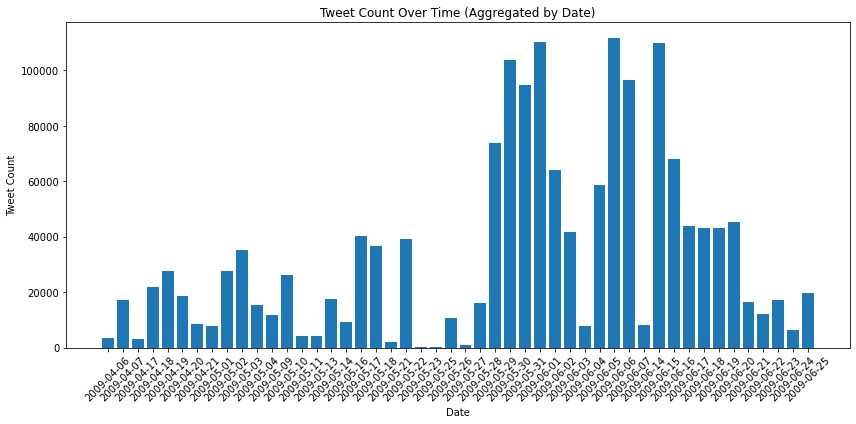

In [21]:
# Plot the tweet count
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts)
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
data = data.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
data = data.orderBy("date")

# Calculate the next date using the lead function
data = data.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
data = data.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
data = data.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = data.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

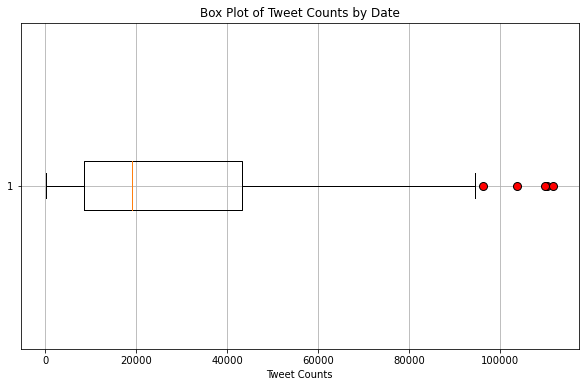

In [23]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in date_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [24]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-05-29, Tweet Count: 73827
Date: 2009-05-30, Tweet Count: 103673
Date: 2009-05-31, Tweet Count: 94588
Date: 2009-06-01, Tweet Count: 110290
Date: 2009-06-02, Tweet Count: 64192
Date: 2009-06-05, Tweet Count: 58757
Date: 2009-06-06, Tweet Count: 111676
Date: 2009-06-07, Tweet Count: 96350
Date: 2009-06-15, Tweet Count: 109781
Date: 2009-06-16, Tweet Count: 67980
Date: 2009-06-20, Tweet Count: 45364


### Initialize Spark Session with Cassandra database

In [25]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder \
    .appName('CassandraIntegration') \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .getOrCreate()

### Read the Data from Cassandra

In [26]:
# Load the data.csv file
cassandraDF = spark.read.csv("file:///home/hduser/Desktop/CA2_SEM2/activity_from_cassandra.csv", header=True, inferSchema=True)

# Display the first 5 rows
cassandraDF.show(5)

# Measure execution time
start_time = time.time()

+------+----------+--------------------+--------+---------------+--------------------+
|number|  id_tweet|                date|   query|        user_id|               tweet|
+------+----------+--------------------+--------+---------------+--------------------+
|865612|1677490053|Sat May 02 02:21:...|NO_QUERY|    arthur01022|'@sarjalis I'm go...|
|820293|1553677142|Sat Apr 18 14:54:...|NO_QUERY|       LONGMANX|'@xxandip how man...|
| 14810|1553861618|Sat Apr 18 15:24:...|NO_QUERY|        a_paige|'I wish @Kimone_i...|
|263293|1986487107|Sun May 31 18:54:...|NO_QUERY|       fredbohm|'Awesome, 2-1 to ...|
|937429|1793224306|Thu May 14 01:51:...|NO_QUERY|princesslaurenn|'has eaten some c...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [27]:
# Print the schema
cassandraDF.printSchema()

root
 |-- number: integer (nullable = true)
 |-- id_tweet: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- tweet: string (nullable = true)



In [28]:
# Check the size of the data
cassandraDF_size = cassandraDF.count()
print(f"The size of the dataset is: {cassandraDF_size} rows")

The size of the dataset is: 1036130 rows


### Exploratory data analysis (EDA)

In [29]:
# Import the necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("CassandraUniqueValues").getOrCreate()

# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = cassandraDF.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

Overall unique value counts:
number: 1036130
id_tweet: 1036130
date: 657323
query: 1
user_id: 506785
tweet: 1036130


In [30]:
# Drop columns that are duplicates and other irrelevant data information
cassandraDF = cassandraDF.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
cassandraDF.show(5)

+--------------------+--------------------+
|                date|               tweet|
+--------------------+--------------------+
|Sat May 02 02:21:...|'@sarjalis I'm go...|
|Sat Apr 18 14:54:...|'@xxandip how man...|
|Sat Apr 18 15:24:...|'I wish @Kimone_i...|
|Sun May 31 18:54:...|'Awesome, 2-1 to ...|
|Thu May 14 01:51:...|'has eaten some c...|
+--------------------+--------------------+
only showing top 5 rows



### Missing Values

In [31]:
# Iterate through all columns and print missing value counts
for column_name in cassandraDF.columns:
    missing_count = cassandraDF.filter(cassandraDF[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

Missing values in 'date': 0
Missing values in 'tweet': 0


In [32]:
# Print the schema
cassandraDF.printSchema()

root
 |-- date: string (nullable = true)
 |-- tweet: string (nullable = true)



In [33]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
cassandraDF = cassandraDF.withColumn("label", cassandraDF["tweet"])

### Descriptive Statistics

In [34]:
# Compute and interpret the mean, median, quartiles and standard deviation of the dataset
cassandraDF.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                date|               tweet|               label|
+-------+--------------------+--------------------+--------------------+
|  count|             1036130|             1036130|             1036130|
|   mean|                null|                null|                null|
| stddev|                null|                null|                null|
|    min|Fri Apr 17 20:30:...|'                ...|'                ...|
|    max|Wed May 27 07:27:...|                test|                test|
+-------+--------------------+--------------------+--------------------+



### Create a configuration to convert string 'date' into timestamp

In [35]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
cassandraDF = cassandraDF.withColumn("date", from_unixtime(unix_timestamp(cassandraDF["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
cassandraDF.select("date").show(5)

+-------------------+
|               date|
+-------------------+
|2009-05-02 02:21:12|
|2009-04-18 14:54:53|
|2009-04-18 15:24:48|
|2009-05-31 18:54:07|
|2009-05-14 01:51:35|
+-------------------+
only showing top 5 rows



### Groupby 'date'

In [36]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in cassandraDF_counts]
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

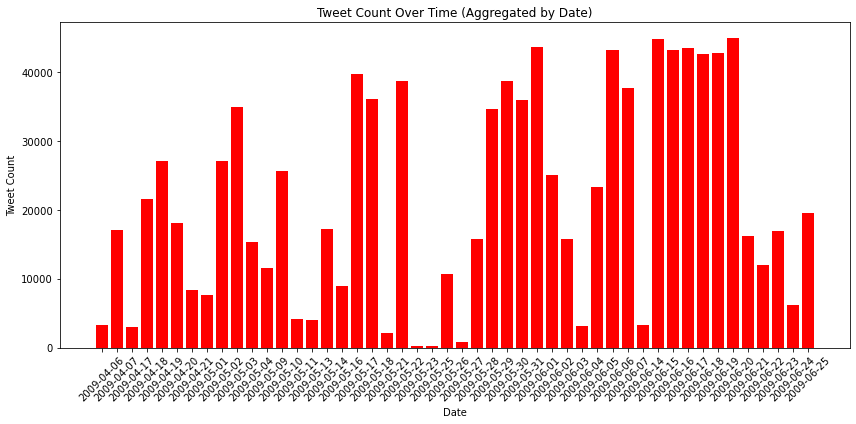

In [37]:
# Plot the tweet count with red bars
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts, color='red')  # Set color to red
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
cassandraDF = cassandraDF.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
cassandraDF = cassandraDF.orderBy("date")

# Calculate the next date using the lead function
cassandraDF = cassandraDF.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
cassandraDF = cassandraDF.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
cassandraDF = cassandraDF.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = cassandraDF.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

First Date: 2009-04-06
Last Date: 2009-06-25


2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13
Missing Days Count: 33


### Outliers

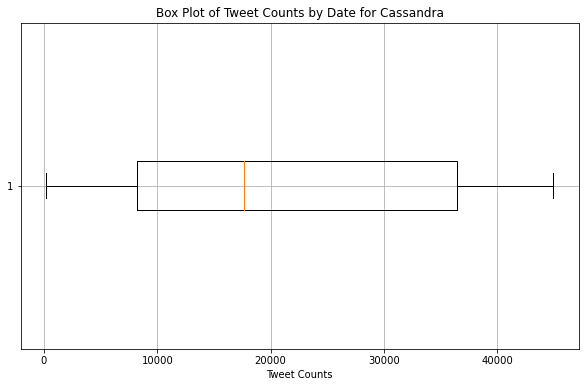

In [39]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date for Cassandra")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [40]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

Potential Outliers:
Date: 2009-06-15, Tweet Count: 44818
Date: 2009-06-20, Tweet Count: 44946


### Comparison between Hive and Cassandra datasets

In [41]:
# Get the row count for 'data'
hive_row_count = data.count()

# Get the row count for 'cassandraDF'
cassandra_row_count = cassandraDF.count()

# Calculate the total difference
total_difference = hive_row_count - cassandra_row_count

# Print the row counts and total difference
print("Hive Database Row Count:", hive_row_count)
print("Cassandra Database Row Count:", cassandra_row_count)
print("Total Difference:", total_difference)

Hive Database Row Count: 1599999
Cassandra Database Row Count: 1036130
Total Difference: 563869


In [42]:
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the 'data' by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
data_date_counts = data.groupBy("date_without_hour").agg(count("*").alias("data_tweet_count"))

# Group 'cassandraDF' by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandra_date_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("cassandra_tweet_count"))

# Sort the data by date without hour
data_date_counts = data_date_counts.orderBy("date_without_hour")
cassandra_date_counts = cassandra_date_counts.orderBy("date_without_hour")

# Collect the data to the driver
data_date_counts = data_date_counts.collect()
cassandra_date_counts = cassandra_date_counts.collect()

# Extract tweet counts and calculate the total difference per day
data_tweet_counts = [row.data_tweet_count for row in data_date_counts]
cassandra_tweet_counts = [row.cassandra_tweet_count for row in cassandra_date_counts]
difference_per_day = [data - cassandra for data, cassandra in zip(data_tweet_counts, cassandra_tweet_counts)]

# Print the tweet counts for both datasets and the total difference beside
for date, data_count, cassandra_count, diff in zip(data_date_counts, data_tweet_counts, cassandra_tweet_counts, difference_per_day):
    print(f"Date: {date.date_without_hour}, Hive Count: {data_count}, Cassandra Count: {cassandra_count}, Total Difference: {diff}")

Date: 2009-04-06, Hive Count: 3359, Cassandra Count: 3321, Total Difference: 38
Date: 2009-04-07, Hive Count: 17311, Cassandra Count: 17119, Total Difference: 192
Date: 2009-04-17, Hive Count: 3084, Cassandra Count: 3047, Total Difference: 37
Date: 2009-04-18, Hive Count: 21754, Cassandra Count: 21506, Total Difference: 248
Date: 2009-04-19, Hive Count: 27469, Cassandra Count: 27136, Total Difference: 333
Date: 2009-04-20, Hive Count: 18460, Cassandra Count: 18128, Total Difference: 332
Date: 2009-04-21, Hive Count: 8587, Cassandra Count: 8423, Total Difference: 164
Date: 2009-05-01, Hive Count: 7716, Cassandra Count: 7568, Total Difference: 148
Date: 2009-05-02, Hive Count: 27434, Cassandra Count: 27125, Total Difference: 309
Date: 2009-05-03, Hive Count: 35333, Cassandra Count: 34902, Total Difference: 431
Date: 2009-05-04, Hive Count: 15481, Cassandra Count: 15293, Total Difference: 188
Date: 2009-05-09, Hive Count: 11739, Cassandra Count: 11588, Total Difference: 151
Date: 2009-05-

### Normal Distribution Comparison

Shapiro-Wilk Test Results:
Data dataset: p-value = 7.3197452366002835e-06, Not Normally Distributed
CassandraDF dataset: p-value = 0.0011485544964671135, Not Normally Distributed


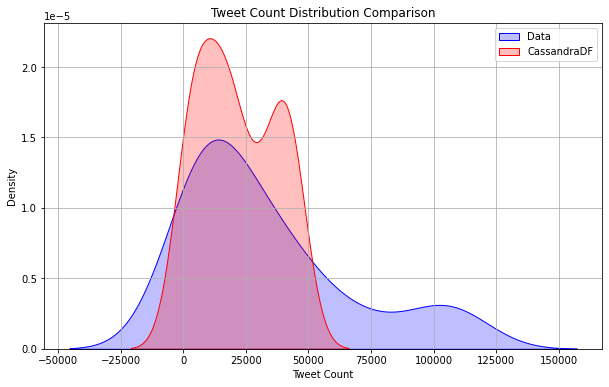

In [43]:
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Extract the tweet counts for both datasets
data_tweet_counts = [row.tweet_count for row in date_counts]
cassandraDF_tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a KDE plot to compare the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data_tweet_counts, label='Data', color='blue', shade=True)
sns.kdeplot(cassandraDF_tweet_counts, label='CassandraDF', color='red', shade=True)
plt.title("Tweet Count Distribution Comparison")
plt.xlabel("Tweet Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Perform the Shapiro-Wilk test to check for normal distribution
data_sw_stat, data_sw_p_value = shapiro(data_tweet_counts)
cassandraDF_sw_stat, cassandraDF_sw_p_value = shapiro(cassandraDF_tweet_counts)

# Print the results of the Shapiro-Wilk test
print("Shapiro-Wilk Test Results:")
print(f"Data dataset: p-value = {data_sw_p_value}, {'Normally Distributed' if data_sw_p_value > 0.05 else 'Not Normally Distributed'}")
print(f"CassandraDF dataset: p-value = {cassandraDF_sw_p_value}, {'Normally Distributed' if cassandraDF_sw_p_value > 0.05 else 'Not Normally Distributed'}")

# Show the plot
plt.show()

### Time execution comparison

In [44]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Hive Execution Time: {execution_time} seconds")

Hive Execution Time: 129.34128403663635 seconds


In [45]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Cassandra Execution Time: {execution_time} seconds")

Cassandra Execution Time: 129.3654613494873 seconds


#### Note: A Comparison of Datasets between Hive and Cassandra.

- While these NoSQL datasets were generated from the original data provided as a study tool, a noticeable difference can be observed in the total number of rows between them:
    - Hive Database Row Count: 1599999
    - Cassandra Database Row Count: 1036130
    - Total Difference: 563869.
- The Hive database was created through HDFS, and was built using the original file, employing Spark commands in the Jupyter notebook. 
- In contrast, the Cassandra database was created within the Cassandra prompt using commands related to tables, keyspaces, and the COPY FROM function, where the original file was utilized.

### Modelling & Natural Language Processing (NLP):

In [46]:
# Check the DataFrame
data.show(5)

2023-11-15 14:16:32,599 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-15 14:16:32,607 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-15 14:16:56,445 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-15 14:17:01,215 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|      date|               tweet|               label|date_without_hour| next_date|is_continuous|group_id|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
|2009-04-06|is upset that he ...|is upset that he ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kenichan I dived...|@Kenichan I dived...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|my whole body fee...|my whole body fee...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@nationwideclass ...|@nationwideclass ...|       2009-04-06|2009-04-07|         true|    3359|
|2009-04-06|@Kwesidei not the...|@Kwesidei not the...|       2009-04-06|2009-04-07|         true|    3359|
+----------+--------------------+--------------------+-----------------+----------+-------------+--------+
only showing top 5 rows



In [47]:
import pandas as pd
from pyspark.sql.functions import concat, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("TweetPreprocessing").getOrCreate()

# Recall the HIVE DataFrame 

# First, create a new column 'tweet' with the same data as 'label'
data = data.withColumn("tweet", data["label"])

# Drop the specified columns
columns_to_drop = ["date_without_hour", "next_date", "is_continuous", "group_id"]
data = data.drop(*columns_to_drop)

# Now, remove the 'label' column and put the text in quotation marks
data = data.drop("label")
data = data.withColumn("tweet", concat(lit('"'), data["tweet"], lit('"')))

# Show the data
data.show(5)

# Save the DataFrame as TweetPreProcessing in Parquet format
data.write.mode("overwrite").save("TweetPreProcessing", format="parquet")

# Convert the Spark DataFrame to a Pandas DataFrame and name it 'df'
df = spark.read.parquet("TweetPreProcessing").toPandas()

# Save the Pandas DataFrame to a CSV file
df.to_csv('processed_data.csv', index=False)

+----------+--------------------+
|      date|               tweet|
+----------+--------------------+
|2009-04-06|"@Kwesidei not th...|
|2009-04-06|"my whole body fe...|
|2009-04-06|"@nationwideclass...|
|2009-04-06|"is upset that he...|
|2009-04-06|"@Kenichan I dive...|
+----------+--------------------+
only showing top 5 rows



### Sentiment Analysis on ProjectTweets

In [48]:
# !pip install pandas langdetect

In [49]:
# Import the necessary libraries
from langdetect import detect

# Initialize a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Display the first 5 rows of the Pandas DataFrame
df.head(5)

,date,tweet
0,2009-06-02,"""English exam today heh cba with it """
1,2009-06-02,"""is at the doctors lets hope i havent done an..."
2,2009-06-02,"""Still terribly upsetting but actually not as ..."
3,2009-06-02,"""@SdPriceless yea. sus. """
4,2009-06-02,"""@JGDerron Sounds like we are on the same page..."


In [50]:
# Check the shape of the Pandas DataFrame
df.shape

(1599999, 2)

### Convert tweets into sentiments

In [1]:
#!pip install vaderSentiment

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Check if the file exists before reading
file_path = '/home/hduser/Desktop/CA2_SEM2/processed_data.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"Error: '{file_path}' not found.")
    # Exit the script or handle the error as needed

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    compound_score = analyzer.polarity_scores(text)['compound']
    return compound_score
    
# Apply the function to the 'tweet' column
df['sentiment'] = df['tweet'].apply(get_sentiment)

# Display the DataFrame with sentiment
print(df)

               date                                              tweet  \
0        2009-06-02              "English exam today heh cba with it "   
1        2009-06-02  "is at the doctors  lets hope i havent done an...   
2        2009-06-02  "Still terribly upsetting but actually not as ...   
3        2009-06-02                          "@SdPriceless yea. sus. "   
4        2009-06-02  "@JGDerron Sounds like we are on the same page...   
...             ...                                                ...   
1599994  2009-06-25  "Sick  Spending my day laying in bed listening...   
1599995  2009-06-25                                  "Gmail is down? "   
1599996  2009-06-25                    "rest in peace Farrah! So sad "   
1599997  2009-06-25  "@Eric_Urbane Sounds like a rival is flagging ...   
1599998  2009-06-25  "has to resit exams over summer...  wishes he ...   

         sentiment  
0          -0.1531  
1           0.4805  
2           0.5529  
3           0.0000  
4     

In [4]:
# Drop the 'tweet' column
df.drop('tweet', axis=1, inplace=True)

# Display the DataFrame with sentiment and without the 'tweet' column
print(df)

               date  sentiment
0        2009-06-02    -0.1531
1        2009-06-02     0.4805
2        2009-06-02     0.5529
3        2009-06-02     0.0000
4        2009-06-02     0.3612
...             ...        ...
1599994  2009-06-25    -0.5106
1599995  2009-06-25     0.0000
1599996  2009-06-25     0.1025
1599997  2009-06-25     0.3612
1599998  2009-06-25     0.1531

[1599999 rows x 2 columns]


In [5]:
# check the type of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1599999 non-null  object 
 1   sentiment  1599999 non-null  float64
dtypes: float64(1), object(1)
memory usage: 24.4+ MB


### Correlation Matrix

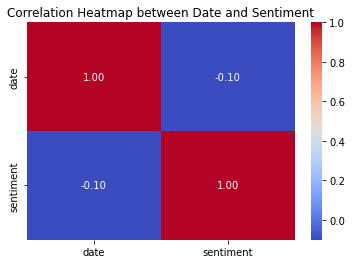

In [6]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title to the heatmap
plt.title('Correlation Heatmap between Date and Sentiment')

# Show the plot
plt.show()

Observation:
- As can be seen, there is no correlation between the features ‘date’ and ‘sentiment’.

In [7]:
# Set the 'datetime' column as the index
df.set_index('date', inplace=True)

# Check the data shape
df.shape

(1599999, 1)

In [8]:
df.head(5)

,sentiment
date,
2009-06-02,-0.1531
2009-06-02,0.4805
2009-06-02,0.5529
2009-06-02,0.0000
2009-06-02,0.3612


In [9]:
# Convert the index to DatetimeIndex
df.index = pd.to_datetime(df.index)

# Resample to daily frequency and aggregate sentiments using mean
df_daily = df.resample('D').mean()

# Resetting the index to have 'date' as a column again
df_daily.reset_index(inplace=True)

# Display the resulting DataFrame
print(df_daily)

         date  sentiment
0  2009-04-06   0.150036
1  2009-04-07   0.166612
2  2009-04-08        NaN
3  2009-04-09        NaN
4  2009-04-10        NaN
..        ...        ...
76 2009-06-21  -0.026057
77 2009-06-22  -0.066730
78 2009-06-23  -0.055286
79 2009-06-24  -0.047146
80 2009-06-25  -0.055777

[81 rows x 2 columns]


### Missing Values

In [10]:
# Create series True or False for NaN data and present data respectively. 
nul_df = pd.isnull(df['sentiment']) 
    
# Print only the data, sentiment = NaN 
df[nul_df]

,sentiment
date,


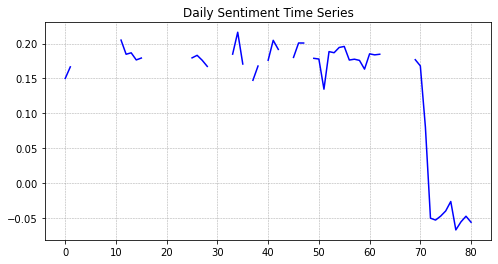

In [11]:
# Set the size of the plot
plt.rcParams['figure.figsize'] = (8, 4)

# Convert index and 'sentiment' column to numpy arrays before plotting
date_values = df_daily.index.to_numpy()
sentiment_values = df_daily['sentiment'].to_numpy()

# Plot the sentiment time series
plt.plot(date_values, sentiment_values, color='blue')

# Add title to the time series plot
plt.title('Daily Sentiment Time Series')

# Add grid lines
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

In [12]:
#!pip install --upgrade scipy

### Linear interpolation
- Before applying time series, it is important to check the missing values, so that there is no disruption between the values ​​that will probably impact the results. 
- For this, in this particular study, Linear interpolation was chosen to deal with missing values, in which it calculates the linear relationship of the data range and thus estimates the missing values, fitting these gaps.

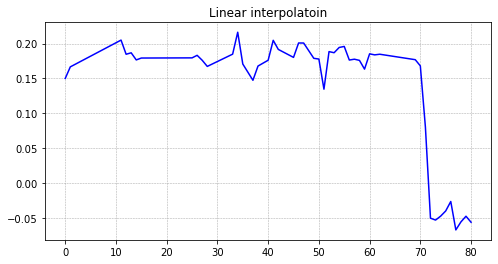

In [13]:
# Set the size of the plot
plt.rcParams['figure.figsize'] = (8, 4)

# Impute the missing values using rolling window method
df_daily['sentiment_L']= df_daily['sentiment'].interpolate(method='linear')

# Plot the complete dataset
plt.plot(df_daily['sentiment_L'], color='blue')

# Add the tittle of the plot as Linear interpolation
plt.title('Linear interpolatoin')

# Add grid lines
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

### Outliers

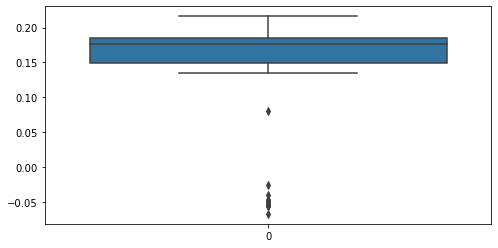

In [14]:
# Create box plots for 'sentiment'
sns.boxplot(df_daily['sentiment'])

# Create a figure 
plt.plot(figsize=(8, 6))

# Show the plot
plt.show()

### Seasonality

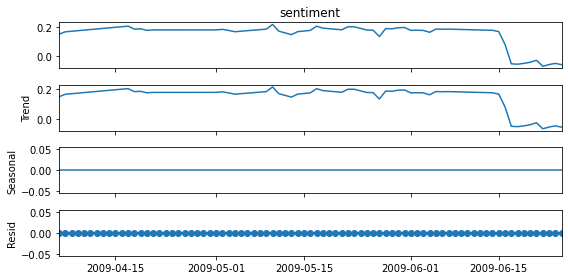

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Call the 'date' column 
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.set_index('date', inplace=True)

# Linear interpolation for missing values
df_daily['sentiment'] = df_daily['sentiment'].interpolate(method='linear')

# Seasonal decomposition
result = seasonal_decompose(df_daily['sentiment'], model='additive', period=1)  # Adjust period based on the expected seasonality

# Plot the decomposition
result.plot()
plt.show()

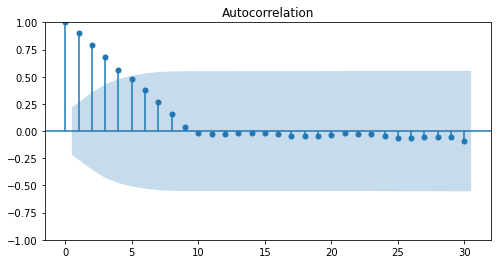

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation Function (ACF)
plot_acf(df_daily['sentiment'], lags=30)
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

# Statistical Tests
result_adf = adfuller(df_daily['sentiment'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -0.3834829330758491
p-value: 0.9128202244524831


### Observation:
- Autocorrelation Function (ACF) plot, indicates a positive values at the beginning that gradually drop below 0 as it move further back in time. it suggests a weakening correlation with past observations. It suggest that there might not be a strong seasonality in the data.
- The p-value associated with the ADF statistic is 0.9128, suggesting that 'fail to reject the null hypothesis of a unit root'. In other words, indicates that the data is non-stationary and the time series may have a unit root or exhibit a trend.

In [19]:
# Print the first and last date
first_date = df_daily.index[0]
last_date = df_daily.index[-1]

print("First Date:", first_date)
print("Last Date:", last_date)

# Print the total count of dates
total_dates = len(df_daily)
print("Total Dates:", total_dates)

First Date: 2009-04-06 00:00:00
Last Date: 2009-06-25 00:00:00
Total Dates: 81


### Split data into train/test sets

In [20]:
# Calculate the percentage split
percentage_train = 0.7
total_days = len(df_daily)
split_index = int(percentage_train * total_days)

# Extract the split date
split_date = df_daily.index[split_index]

# Create training and testing sets
train = df_daily[df_daily.index < split_date]
test = df_daily[df_daily.index >= split_date]

# Print the testing set
print(test)

            sentiment  sentiment_L
date                              
2009-06-01   0.176357     0.176357
2009-06-02   0.177577     0.177577
2009-06-03   0.175895     0.175895
2009-06-04   0.163375     0.163375
2009-06-05   0.185255     0.185255
2009-06-06   0.183769     0.183769
2009-06-07   0.184681     0.184681
2009-06-08   0.183565     0.183565
2009-06-09   0.182450     0.182450
2009-06-10   0.181334     0.181334
2009-06-11   0.180219     0.180219
2009-06-12   0.179103     0.179103
2009-06-13   0.177988     0.177988
2009-06-14   0.176872     0.176872
2009-06-15   0.168013     0.168013
2009-06-16   0.080436     0.080436
2009-06-17  -0.049929    -0.049929
2009-06-18  -0.052644    -0.052644
2009-06-19  -0.047040    -0.047040
2009-06-20  -0.039624    -0.039624
2009-06-21  -0.026057    -0.026057
2009-06-22  -0.066730    -0.066730
2009-06-23  -0.055286    -0.055286
2009-06-24  -0.047146    -0.047146
2009-06-25  -0.055777    -0.055777


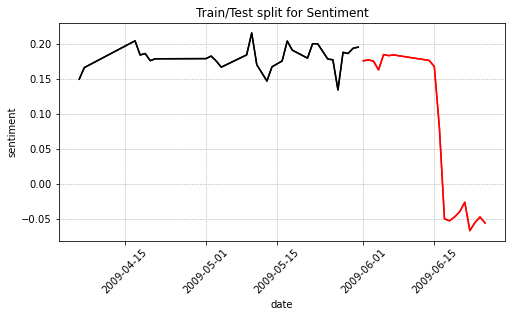

In [23]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('sentiment')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sentiment")
plt.grid(color='darkgray', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
resample daily
imputation
seazonality (ML DOES NOT NEED)
trend (ML DOES NOT NEED)
split the data
training - 2 simple model
hyperparameter the model
prediction
forecasting
DASHBOARD

#MAE



In [3]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Display the count of each sentiment
print(sentiment_counts)

# Plot the Sentiment visualization graph
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='summer')

sentiment
 0.0000    423058
 0.4404     30862
 0.3612     20192
 0.4019     17385
-0.2960     17051
            ...  
-0.7280         1
 0.2061         1
-0.0707         1
-0.1475         1
 0.5219         1
Name: count, Length: 18237, dtype: int64


/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='sentiment', ylabel='count'>

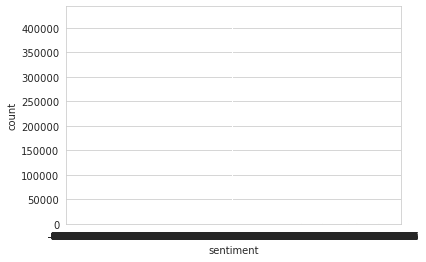

In [4]:
# Plot the Sentiment visualization graph
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='summer')

In [5]:
# Data Preprocessing
df_positive = df[df['sentiment'] == 'positive'][0:8000]
df_neutral = df[df['sentiment'] == 'neutral']
df_negative = df[df['sentiment'] == 'negative']

# Sample negative and neutral dataset and create the final dataframe
df_neutral_over = df_neutral.sample(8000, replace=True)
df_negative_over = df_negative.sample(8000, replace=True)

df = pd.concat([df_positive, df_neutral_over, df_negative_over], axis=0)

In [6]:
# Text Preprocessing

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from string import punctuation

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    processed_text = ' '.join([word for word in no_punctuation.split() if word.lower() not in stop_words])
    return processed_text

# Apply the preprocessing function directly on the 'tweet' column
df['tweet review'] = df['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Visualize Tweet Review with Sentiment

df = df[['tweet review', 'sentiment']]
df.head()

df.shape

(24000, 2)

In [8]:
# Apply One hot encoding on negative, neutral, and positive

one_hot = pd.get_dummies(df["sentiment"])
df.drop(['sentiment'], axis=1, inplace=True)
df = pd.concat([df, one_hot], axis=1)

# Convert boolean columns to integers (0 and 1)
df['negative'] = df['negative'].astype(int)
df['neutral'] = df['neutral'].astype(int)
df['positive'] = df['positive'].astype(int)

df.head()

,tweet review,negative,neutral,positive
1,doctors lets hope havent done anything serious...,0,0,1
2,Still terribly upsetting actually awful true f...,0,0,1
4,JGDerron Sounds like page tonight,0,0,1
7,4everBrandy tryin 2 show fav artist LUV Ill ba...,0,0,1
10,overtime wil busy period ever end Extra cash g...,0,0,1


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn.functional as F

# Apply Train Test Split
X = df['tweet review'].values
y = df.drop('tweet review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize your text data (simple example using CountVectorizer)
vect = CountVectorizer()
X_train_counts = vect.fit_transform(X_train)
X_test_counts = vect.transform(X_test)

In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_counts.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_counts.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Assuming y_train is one-hot encoded
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Assuming y_test is one-hot encoded

# Define the DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained word embeddings (GloVe in this example)
embedding_dim = 100  # Adjust based on the dimensions of the chosen pre-trained embeddings
glove = GloVe(name='6B', dim=embedding_dim)

# Simple neural network model with linear layer
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_size)

    def forward(self, x):
        output = self.fc(x)
        return output

# Instantiate the model
input_dim = X_train_tensor.shape[1]  # Adjust based on the dimensions of the input data
output_size = len(y_train[0])  # Adjust based on the actual number of classes in the target variable
model = SimpleClassifier(input_dim, output_size)

# Define the loss function and optimizer
criterion = F.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
### Training the Model
# Early stopping parameters
early_stop = False
patience = 5  # Number of epochs to wait for improvement
best_validation_loss = float('inf')
counter = 0  # Counter for epochs without improvement

# Lists to store training loss and validation accuracy
train_loss_values = []
validation_accuracy_values = []

# Training loop
epochs = 100
verbose = 1

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation accuracy calculation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_validation_loss = 0.0  # Add this line to track validation loss
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            total_validation_loss += loss.item()  # Accumulate validation loss
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_loss = total_validation_loss / len(test_loader)  # Calculate average validation loss
        accuracy = correct / total
        validation_accuracy_values.append(accuracy)
        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}, Validation Loss: {validation_loss:.4f}')

        # Early stopping check
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
                early_stop = True
                break

    # Calculate average training loss for the epoch
    average_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(average_train_loss)

# Test accuracy calculation after training loop
if not early_stop:  # Don't run if early stopping occurred
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            predicted = torch.round(torch.sigmoid(outputs))  # Adjust for one-hot encoding
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        test_loss /= len(test_loader)

        print(f'Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}')

Epoch 1/100, Loss: 0.5495, Validation Accuracy: 2.0681, Validation Loss: 0.5769
Epoch 2/100, Loss: 0.5195, Validation Accuracy: 2.1179, Validation Loss: 0.5511
Epoch 3/100, Loss: 0.4953, Validation Accuracy: 2.1682, Validation Loss: 0.5297
Epoch 4/100, Loss: 0.4752, Validation Accuracy: 2.2400, Validation Loss: 0.5117
Epoch 5/100, Loss: 0.4586, Validation Accuracy: 2.3181, Validation Loss: 0.4963
Epoch 6/100, Loss: 0.4441, Validation Accuracy: 2.3715, Validation Loss: 0.4830
Epoch 7/100, Loss: 0.4317, Validation Accuracy: 2.4074, Validation Loss: 0.4716
Epoch 8/100, Loss: 0.4206, Validation Accuracy: 2.4340, Validation Loss: 0.4615
Epoch 9/100, Loss: 0.4112, Validation Accuracy: 2.4512, Validation Loss: 0.4527
Epoch 10/100, Loss: 0.4026, Validation Accuracy: 2.4674, Validation Loss: 0.4449
Epoch 11/100, Loss: 0.3951, Validation Accuracy: 2.4811, Validation Loss: 0.4379
Epoch 12/100, Loss: 0.3884, Validation Accuracy: 2.4893, Validation Loss: 0.4318
Epoch 13/100, Loss: 0.3820, Validatio

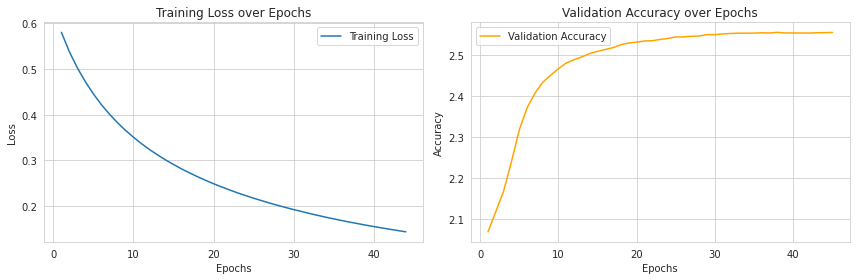

In [13]:
import matplotlib.pyplot as plt

#  Plotting
plt.figure(figsize=(12, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(validation_accuracy_values) + 1), validation_accuracy_values, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation of Model

In [14]:
# Set the model in evaluation mode
model.eval()  

with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0.0  # Added to accumulate the total loss

    for inputs, labels in test_loader:  # Use the test_loader instead
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Assuming you have a criterion defined
        total_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)  # Compute the average loss

    print('Test loss:', average_loss)
    print('Test accuracy:', accuracy)


Test loss: 0.38092855357490807
Test accuracy: 2.555972222222222


### Prediction

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    new_data = ...  # Replace with the new data
    predicted_labels = model(new_data)

preds.shape

### References:

• https://github.com/apache/hive

• https://cassandra.apache.org/doc/latest/cassandra/cql/ddl.html

• Cassandra: The Definitive Guide, (Revised) Third Edition, 3rd Edition, Jeff Carpenter, Eben Hewitt,
O'Reilly Media, Inc., January 2022.